In [132]:
!pip install kagglehub


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [134]:
from kagglehub import dataset_load, KaggleDatasetAdapter

np.random.seed(42)

df = dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "yasserh/titanic-dataset",
    "Titanic-Dataset.csv"
)
df_original = df.copy()

print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [135]:
print(f'survived={len(df[df["Survived"]==1])}')
print(f'dead={len(df[df["Survived"]==0])}')

survived=342
dead=549


In [136]:
print(df.columns)
print("\nMissing values:")
print(df.isnull().sum())
print("Entries:", len(df)) # 891

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Entries: 891


In [137]:
# impute by median and mode
# df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [138]:
# which one is easy to do one-hot?
print(df["Embarked"].unique(), df["Ticket"].unique())
# clearly embarked is easy, and ticket needs some work (not complicated, tho. We can extract the first strings if we want to. Skip for now.)

['S' 'C' 'Q'] ['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29395' 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879'
 '2680' '1601' '348123' '349208' '374746' '248738' '364516' '345767'
 '345779' '330932' '113059' 'SO/C 14885' '3101278' 'W./C. 6608'
 'SOTON/OQ 392086' '343275' '343276' '347466' 'W.E.P. 5734' 'C.A. 2315'
 '364500' '374910' 'PC 17754' 'PC 17759' '231919' '244367' '349245'
 '349

In [139]:
print(len(df["Cabin"].unique()))
df = df.drop(columns=["Cabin", "Name", "Ticket"]) # drops...
# but we can instead do feature engineering for Cabin. Just make a col "HasCabin".
# we could extract titles, which might be helpful, but we will skip it for now.

148


In [140]:
# one hot
categorical_cols = ["Sex", "Embarked", "Pclass"]

df = pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True)

In [141]:
# feature engineering
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

In [142]:
# We could do median imputation, but try to predict the age and impute them
age_df = df.copy() #.drop(columns=["Name", "Ticket"])

# Encode simple categorical features first
# age_df = pd.get_dummies(age_df, columns=["Sex", "Embarked",], drop_first=True)
age_df["Age"] = df_original["Age"] # because we imputed age by median!

# Separate known / unknown ages
age_known = age_df[age_df["Age"].notnull()]
age_unknown = age_df[age_df["Age"].isnull()]

from sklearn.model_selection import train_test_split

X_age = age_known.drop("Age", axis=1)
y_age = age_known["Age"]

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42
)

X_age_pred = age_unknown.drop("Age", axis=1)

# from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor

# age_model = RandomForestRegressor(n_estimators=200, max_depth=10)
age_model = XGBRFRegressor()

age_model.fit(X_train_age, y_train_age)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_age = age_model.predict(X_test_age)

mae = mean_absolute_error(y_test_age, y_pred_age)
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_age))
r2 = r2_score(y_test_age, y_pred_age)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

median_pred = np.full_like(y_test_age, y_train_age.median())
median_mae = mean_absolute_error(y_test_age, median_pred)

print("\nMedian MAE:", median_mae)
print("Model MAE:", mae)

if mae <= median_mae:
    predicted_ages = age_model.predict(X_age_pred)
    df.loc[age_unknown.index, "Age"] = predicted_ages
else:
    median_age = y_train_age.median() # avoiding data leakage
    df.loc[age_unknown.index, "Age"] = median_age
    
# 1 year improvement. Maybe this way imputation is slightly more effective?

MAE: 9.061351616065819
RMSE: 11.387082717588413
R2: 0.3006326052400502

Median MAE: 10.804195804195805
Model MAE: 9.061351616065819


In [143]:
print(df.columns)
print(df.dtypes)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'FamilySize', 'IsAlone'],
      dtype='object')
PassengerId      int64
Survived         int64
Pclass           int64
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Sex_male          bool
Embarked_Q        bool
Embarked_S        bool
FamilySize       int64
IsAlone          int32
dtype: object


In [144]:
from sklearn.model_selection import train_test_split

y = df["Survived"]
X = df.drop(columns=["Survived"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def train_eval_predict(X_train, y_train, X_test, y_test):
    # Training
    model = RandomForestClassifier(n_estimators=100, criterion='log_loss', max_depth=32)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation
    cm = confusion_matrix(y_test, y_pred)

    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    print(cm_df, end="\n\n")

    # more conveniently, this method works
    print(classification_report(y_test, y_pred))
    
    return model, y_pred

In [146]:
model, y_pred = train_eval_predict(X_train, y_train, X_test, y_test)

          Predicted 0  Predicted 1
Actual 0          120           17
Actual 1           27           59

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       137
           1       0.78      0.69      0.73        86

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



In [147]:
# median imputation
#           Predicted 0  Predicted 1
# Actual 0          117           20
# Actual 1           27           59

#               precision    recall  f1-score   support

#            0       0.81      0.85      0.83       137
#            1       0.75      0.69      0.72        86

# ML-based imputation improved the prediction by 1 year on average, 
# but it shows a visible small positive impact :)))

In [148]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# not bad

Accuracy: 0.8026905829596412
Precision: 0.7763157894736842
Recall: 0.686046511627907
F1 Score: 0.7283950617283951


ROC AUC: 0.857


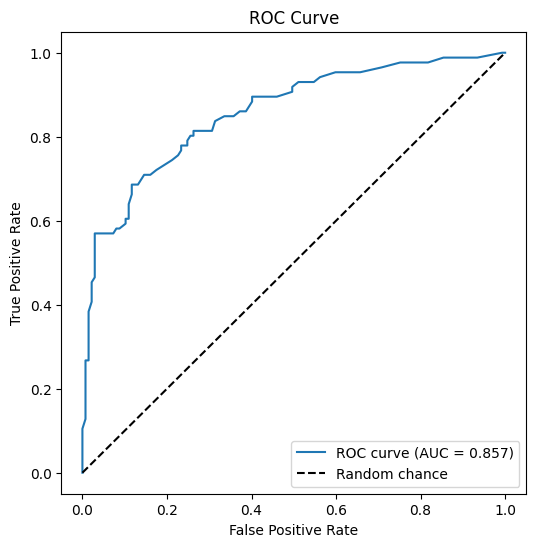

In [150]:
from sklearn.metrics import roc_auc_score, roc_curve

# 1. Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]  # probability of class 1

# 2. Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.3f}")

# 3. Optional: plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

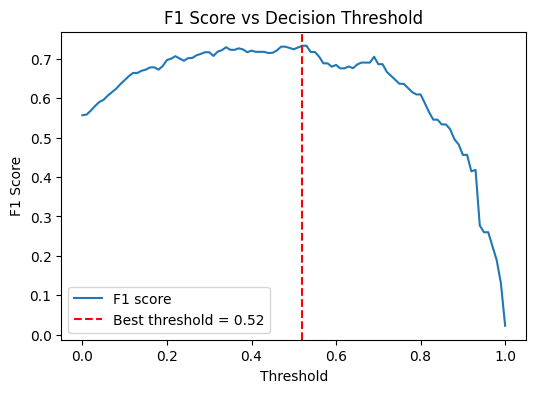

Optimal threshold: 0.52 with F1 score: 0.733


In [151]:
# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Generate thresholds from 0 to 1
thresholds = np.linspace(0, 1, 101)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

# Find the threshold with the maximum F1
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Plot F1 vs threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores, label="F1 score")
plt.axvline(best_thresh, color='r', linestyle='--', label=f"Best threshold = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Decision Threshold")
plt.legend()
plt.show()

print(f"Optimal threshold: {best_thresh:.2f} with F1 score: {best_f1:.3f}")